In [1]:
%pylab inline
%matplotlib inline
import os, sys, gzip
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


### Notebook to evaluate the number of events as a function of t(events) for the urns data, dividing the nodes by their entrance time...

In [3]:
# The input directory...
IDir = '../../data/'

nbins = 50

nTSteps = 50

First_Analysis = 1e+3 # First time (in events) to do the analysis...

In [4]:
fnames = sorted(os.listdir(IDir))

TMax = float(IDir.split('_')[4][1:])

Rho = float(IDir.split('_')[2][1:])
Nu = float(IDir.split('_')[3][1:])

Ratio = Rho/Nu

Entrance_bins = np.ceil(np.logspace(.0, np.log10(TMax+1.), nbins+1))

Measure_Times = np.ceil(np.logspace(np.log10(First_Analysis), np.log10(TMax), nTSteps))


AVG_Number_of_Events = np.zeros((nbins, nTSteps), dtype=float128)
AVG_Number_of_Appearances = np.zeros((nbins, nTSteps), dtype=float128)

NUM_of_urns_per_entrance_bin = np.zeros(nbins, dtype=float128)

Seen_IDs = {}

Ev_Count = 0


Entrance_Bin = 0
Next_Entrance_Bin = Entrance_bins[Entrance_Bin+1]

Measure_Time_indx = 0
Next_Analysis_Time = Measure_Times[Measure_Time_indx]

for fn in fnames:
    sys.stdout.write("\r File %s ..." % fn)
    sys.stdout.flush()
    Listone = []
    f = gzip.open(os.path.join(IDir, fn), 'rb')
    for l in f:
        Listone.append(l.strip().split()[:2])
    f.close()
    
    Caller = True
    for values in Listone:
        Ev_Count += 1
        for ID in values:
            tmp_bin = Entrance_Bin
            if ID not in Seen_IDs:
                Seen_IDs[ID] = Entrance_Bin
                NUM_of_urns_per_entrance_bin[Entrance_Bin] += 1.
            else:
                tmp_bin = Seen_IDs[ID]
                
            if Caller:
                AVG_Number_of_Events[tmp_bin, Measure_Time_indx] += 1.
            Caller = not Caller
            
            AVG_Number_of_Appearances[tmp_bin, Measure_Time_indx] += 1.
            
        if Ev_Count >= Next_Entrance_Bin:
            Entrance_Bin += 1
            Next_Entrance_Bin = Entrance_bins[Entrance_Bin+1]
        
        if Ev_Count >= Next_Analysis_Time:
            # Copy the running cumulative number of events per bin to the next temporal slice
            Flag = False
            if Measure_Time_indx < nTSteps - 1:
                AVG_Number_of_Events[:, Measure_Time_indx+1] = AVG_Number_of_Events[:, Measure_Time_indx]
                Flag = True
            
            # Doing the average...
            for i, num_of_urns in enumerate(NUM_of_urns_per_entrance_bin):
                if num_of_urns > .0:
                    AVG_Number_of_Events[i, Measure_Time_indx] /= num_of_urns
                    
            if Flag:
                Measure_Time_indx += 1     
                Next_Analysis_Time = Measure_Times[Measure_Time_indx]
                

 File time_000099.dat ...

(50, 50) (50,)


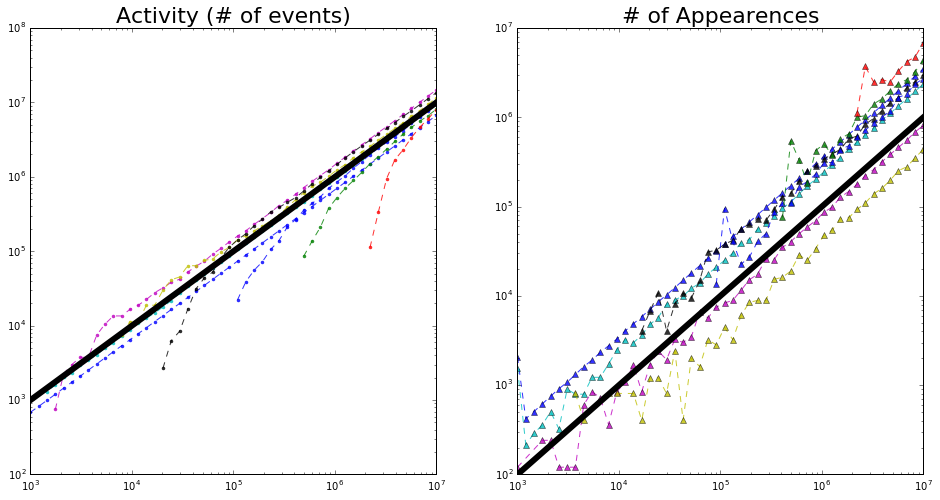

In [6]:
print AVG_Number_of_Events.shape, Measure_Times.shape
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(121)
ax2 = fig1.add_subplot(122)
for i in range(0, nbins, 5):
    X = Measure_Times
    Y = AVG_Number_of_Events[i,:] * (Entrance_bins[1:]+Entrance_bins[:-1])[i]/2.
    
    X = X[Y > 0]
    Y = Y[Y > 0]
    
    ax1.loglog(X, Y, '.--', alpha=.8)
    
    X = Measure_Times
    Y = AVG_Number_of_Appearances[i,:] * (Entrance_bins[1:]+Entrance_bins[:-1])[i]**.75/2.
    
    X = X[Y > 0]
    Y = Y[Y > 0]
    
    ax2.loglog(X, Y, '^--', alpha=.8)
    
XTheo = np.logspace(np.log10(First_Analysis), np.log10(TMax))
ax1.loglog(XTheo, XTheo, '-k', lw=6)#**(Nu/2./Rho))
ax1.set_title("Activity (# of events)", size=22)

ax2.loglog(XTheo, XTheo/10., '-k', lw=6)#**(Nu/2./Rho))
ax2.set_title("# of Appearences", size=22)